# Training differentially private pipelines

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [1]:
import warnings

import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from diffprivlib import models

In [2]:
X_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ")
y_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=", ")

In [3]:
np.unique(y_train)

array(['<=50K', '>50K'], dtype='<U5')

In [4]:
X_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=", ", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=", ", skiprows=1)
# Must trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

In [5]:
np.unique(y_test)

array(['<=50K', '>50K'], dtype='<U5')

## Pipeline with no privacy

To begin, let's train and test a scikit-learn pipeline without any privacy guarantees. We first use `StandardScaler` to normalise the data to zero mean and unit variance, then use `PCA` to reduce the dimensionality of the system, and then use `LogisticRegression` as a classifier.

In [6]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(2)),
    ('lr', LogisticRegression(solver="lbfgs"))
])

We now train the model, and save the test accuracy as a baseline.

In [7]:
from sklearn.metrics import accuracy_score

pipe.fit(X_train, y_train)
baseline = accuracy_score(y_test, pipe.predict(X_test))
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 80.30%


## Differentially private pipeline

Using `diffprivlib`, we can now train a differentially private pipeline. We use the same components as in our pipeline above, but with each component satisfying differential privacy. We decide on the `range` and `data_norm` parameters by trial and error for this example. In practice, these hyperparameters should be chosen using non-private data, i.e. from metadata provided by the data owner.

In [8]:
epsilons = np.logspace(-2, 1, 500)

dp_pipe = Pipeline([
    ('scaler', models.StandardScaler(range=[73, 15, 100000, 4400, 98])),
    ('pca', models.PCA(2, data_norm=20, centered=True)),
    ('lr', models.LogisticRegression(data_norm=20))
])

Let's now train the pipeline across a range of epsilons. We will only store the value if a warning is not raised. In some cases a `PrivacyLeakWarning` is raised, because the data from the scaling and/or dimensionality reduction falls outside the `data_norm` bound given above.

In [9]:
pipe_accuracy = []
warned = 0

for epsilon in epsilons:
    _eps = epsilon / 3
    dp_pipe.set_params(scaler__epsilon=_eps, pca__epsilon=_eps, lr__epsilon=_eps)
    
    with warnings.catch_warnings(record=True) as w:
        dp_pipe.fit(X_train, y_train)
        
        # Only record if warning not raised
        if len(w) > 0:
            warned += 1
            pipe_accuracy.append(np.NaN)
        else:
            pipe_accuracy.append(accuracy_score(y_test, dp_pipe.predict(X_test)))
    
print("Warnings raised %d times from %d runs, %.2f%%." % (warned, len(epsilons), warned / len(epsilons) * 100))

Warnings raised 37 times from 500 runs, 7.40%.


Let's save the results so they can be used later.

In [10]:
import pickle

pickle.dump((epsilons, baseline, pipe_accuracy), open("pipeline_accuracy_500.p", "wb" ) )

## Results

We can now plot the results, showing that non-private accuracy is obtained consistently from `epsilon = 1`.

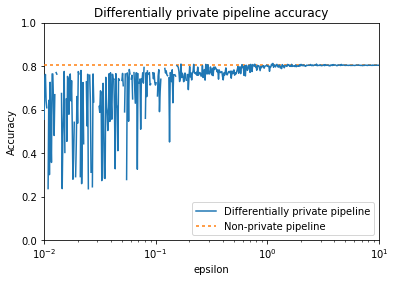

In [11]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, pipe_accuracy = pickle.load(open("pipeline_accuracy_500.p", "rb"))

plt.semilogx(epsilons, pipe_accuracy, label="Differentially private pipeline", zorder=10)
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private pipeline", zorder=5)
plt.title("Differentially private pipeline accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=4)
plt.show()